In [40]:
import pandas as pd
from pulp import LpProblem, LpMaximize, LpVariable, lpSum, LpBinary, LpStatus, value, PULP_CBC_CMD


# -------------------------
# Load CSVs
# -------------------------
blocks = pd.read_csv("/Users/muskansingh/OR-MILP/or-milp-env/data-folder/blocks.csv")
loops = pd.read_csv("/Users/muskansingh/OR-MILP/or-milp-env/data-folder/loops.csv")
stations = pd.read_csv("/Users/muskansingh/OR-MILP/or-milp-env/data-folder/stations.csv")
passenger_trains = pd.read_csv("/Users/muskansingh/OR-MILP/or-milp-env/data-folder/scheduled_trains.csv")
goods_trains = pd.read_csv("/Users/muskansingh/OR-MILP/or-milp-env/data-folder/unscheduled_trains.csv")

# Merge passenger and goods trains
passenger_trains = passenger_trains.reset_index(drop=True)
passenger_trains['train_id'] = passenger_trains.index

goods_trains = goods_trains.reset_index(drop=True)
goods_trains['train_id'] = goods_trains.index + len(passenger_trains)

trains = pd.concat([passenger_trains, goods_trains], ignore_index=True)
trains['train_id'] = trains.index

# -------------------------
# MILP Model
# -------------------------
model = LpProblem("Maximize_Throughput", LpMaximize)

# -------------------------
# Decision Variables (Blocks + Loops)
# -------------------------
e = {}  # entry time
l = {}  # exit time
x = {}  # train occupies section (block or loop)
y = {}  # precedence between trains in same section

M = 10000  # big-M for precedence constraints

# --- Blocks ---
for t_id, t_row in trains.iterrows():
    for b_id, b_row in blocks.iterrows():
        key = (t_row.train_id, b_row.block_id)
        e[key] = LpVariable(f"e_{t_row.train_id}_{b_row.block_id}", lowBound=0)
        l[key] = LpVariable(f"l_{t_row.train_id}_{b_row.block_id}", lowBound=0)
        x[key] = LpVariable(f"x_{t_row.train_id}_{b_row.block_id}", cat=LpBinary)

# --- Loops ---
for t_id, t_row in trains.iterrows():
    for l_id, l_row in loops.iterrows():
        key = (t_row.train_id, l_row.loop_id)
        e[key] = LpVariable(f"e_{t_row.train_id}_{l_row.loop_id}", lowBound=0)
        l[key] = LpVariable(f"l_{t_row.train_id}_{l_row.loop_id}", lowBound=0)
        x[key] = LpVariable(f"x_{t_row.train_id}_{l_row.loop_id}", cat=LpBinary)

# --- Precedence variables for conflicts (blocks + loops) ---
for section in pd.concat([blocks[['block_id']], loops[['loop_id']]], ignore_index=True).itertuples():
    section_id = getattr(section, 'block_id', None) or getattr(section, 'loop_id', None)
    for i, t1 in trains.iterrows():
        for j, t2 in trains.iterrows():
            if t1.train_id >= t2.train_id:
                continue
            y[t1.train_id, t2.train_id, section_id] = LpVariable(f"y_{t1.train_id}_{t2.train_id}_{section_id}", cat=LpBinary)

# -------------------------
# Objective Function
# -------------------------
# Maximize number of trains completing the last block
model += lpSum([x[t_row.train_id, blocks.iloc[-1].block_id] for _, t_row in trains.iterrows()]), "Maximize_Throughput"

# -------------------------
# Constraints
# -------------------------

# 1. Block travel time constraints
for t_id, t_row in trains.iterrows():
    for b_id, b_row in blocks.iterrows():
        block_length = b_row.end_km - b_row.start_km
        max_speed = min(t_row.get('max_speed_kmph', 110), b_row.block_velocity_kmph)
        travel_time = block_length / max_speed * 60  # minutes
        model += l[t_row.train_id, b_row.block_id] >= e[t_row.train_id, b_row.block_id] + travel_time, f"TravelTime_{t_row.train_id}_{b_row.block_id}"

# 2. Signal constraints (no two trains occupy the same section at same time)
for section in pd.concat([blocks[['block_id']], loops[['loop_id']]], ignore_index=True).itertuples():
    if hasattr(section, 'block_id') and pd.notna(section.block_id):
        section_id = section.block_id
    elif hasattr(section, 'loop_id') and pd.notna(section.loop_id):
        section_id = section.loop_id
    else:
        continue  # skip invalid rows

    for i, t1 in trains.iterrows():
        for j, t2 in trains.iterrows():
            if t1.train_id >= t2.train_id:
                continue
            y[t1.train_id, t2.train_id, section_id] = LpVariable(f"y_{t1.train_id}_{t2.train_id}_{section_id}", cat=LpBinary)

# 3. Loop capacity constraints
for l_id, loop_row in loops.iterrows():
    loop_length = loop_row.get('loop_length_km', 1.0)
    model += lpSum([trains.loc[t, 'train_length_km'] * x[(trains.loc[t,'train_id'], loop_row.loop_id)]
                    for t in trains.index]) <= loop_length, f"LoopCapacity_{loop_row.loop_id}"

# 4. Goods train start time
for t_id, t_row in goods_trains.iterrows():
    first_block = blocks.iloc[0]['block_id']
    model += e[t_row['train_id'], first_block] >= t_row['start_time_min_allowed'], f"GoodsStart_{t_row['train_id']}"


# 5. Direction conflict (up/down trains cannot occupy same block)
up_trains = trains[trains.direction=='up']
down_trains = trains[trains.direction=='down']
for b_id, b_row in blocks.iterrows():
    for _, t_up in up_trains.iterrows():
        for _, t_down in down_trains.iterrows():
            model += x[t_up.train_id, b_row.block_id] + x[t_down.train_id, b_row.block_id] <= 1, f"Direction_{t_up.train_id}_{t_down.train_id}_{b_row.block_id}"



In [41]:
model.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/mk/tvz_pqr97_778k6rbbp07ylm0000gn/T/ae4a12fc89f2437f8d08bea4240ab7c0-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/mk/tvz_pqr97_778k6rbbp07ylm0000gn/T/ae4a12fc89f2437f8d08bea4240ab7c0-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38243 COLUMNS
At line 130669 RHS
At line 168908 BOUNDS
At line 174859 ENDATA
Problem MODEL has 38238 rows, 9690 columns and 80440 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 55 - 0.02 seconds
Cgl0004I processed model has 1650 rows, 85 columns (85 integer (85 of which binary)) and 3300 elements
Cutoff increment increased from 1e-05 to 0.9999
Cbc0038I Initial state - 0 integers unsatisfied sum 

1

In [42]:
# -------------------------
# Safe Output Results
# -------------------------

print(f"Status: {LpStatus[model.status]}\n")

# Helper function to safely format values
def safe_value(var):
    v = value(var)
    return f"{v:.2f}" if v is not None else "N/A"

# Print block results
print("=== Block Results ===")
for t_id, t_row in trains.iterrows():
    for b_id, b_row in blocks.iterrows():
        var_key = (t_row['train_id'], b_row['block_id'])
        if var_key in e and var_key in l and var_key in x:
            print(f"Train {t_row['train_id']} Block {b_row['block_id']}: "
                  f"Entry {safe_value(e[var_key])} min, "
                  f"Exit {safe_value(l[var_key])} min, "
                  f"Occupy {safe_value(x[var_key])}")

# Print loop results
if loops.shape[0] > 0:
    print("\n=== Loop Results ===")
    for t_id, t_row in trains.iterrows():
        for l_id, l_row in loops.iterrows():
            var_key = (t_row['train_id'], l_row['loop_id'])
            if var_key in e and var_key in l and var_key in x:
                print(f"Train {t_row['train_id']} Loop {l_row['loop_id']}: "
                      f"Entry {safe_value(e[var_key])} min, "
                      f"Exit {safe_value(l[var_key])} min, "
                      f"Occupy {safe_value(x[var_key])}")


Status: Optimal

=== Block Results ===
Train 0 Block 10010: Entry 0.00 min, Exit 2.40 min, Occupy 0.00
Train 0 Block 11010: Entry 0.00 min, Exit 2.40 min, Occupy 0.00
Train 0 Block 20010: Entry 0.00 min, Exit 3.00 min, Occupy 0.00
Train 0 Block 21010: Entry 0.00 min, Exit 6.60 min, Occupy 0.00
Train 0 Block 30010: Entry 0.00 min, Exit 6.00 min, Occupy 0.00
Train 0 Block 31010: Entry 0.00 min, Exit 6.00 min, Occupy 0.00
Train 0 Block 40010: Entry 0.00 min, Exit 3.60 min, Occupy 0.00
Train 0 Block 41010: Entry 0.00 min, Exit 3.60 min, Occupy 0.00
Train 0 Block 50010: Entry 0.00 min, Exit 5.40 min, Occupy 0.00
Train 0 Block 51010: Entry 0.00 min, Exit 5.40 min, Occupy 0.00
Train 0 Block 60010: Entry 0.00 min, Exit 1.80 min, Occupy 0.00
Train 0 Block 61010: Entry 0.00 min, Exit 1.80 min, Occupy 0.00
Train 0 Block 70010: Entry 0.00 min, Exit 3.00 min, Occupy 0.00
Train 0 Block 71010: Entry 0.00 min, Exit 3.00 min, Occupy 0.00
Train 0 Block 80010: Entry 0.00 min, Exit 3.00 min, Occupy 0.00
T

In [43]:
# Suppose last_block is the final block
last_block = blocks.iloc[-1]['block_id']

# Objective value from MILP
milp_throughput = value(model.objective)
print("MILP throughput:", milp_throughput)

# Try to force one extra train
extra_train_id = max(trains['train_id']) + 1
e[(extra_train_id, last_block)] = LpVariable(f"e_{extra_train_id}_{last_block}", lowBound=0)
l[(extra_train_id, last_block)] = LpVariable(f"l_{extra_train_id}_{last_block}", lowBound=0)
x[(extra_train_id, last_block)] = LpVariable(f"x_{extra_train_id}_{last_block}", cat=LpBinary)

# Add constraint: extra train must complete last block
model += x[(extra_train_id, last_block)] == 1, f"ForceExtra_{extra_train_id}"

model.solve()
print("Objective with extra train:", value(model.objective))
print("Status:", LpStatus[model.status])


MILP throughput: 55.0
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/mk/tvz_pqr97_778k6rbbp07ylm0000gn/T/19c78ce07fce4126a878965e9c4cb042-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/mk/tvz_pqr97_778k6rbbp07ylm0000gn/T/19c78ce07fce4126a878965e9c4cb042-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 38244 COLUMNS
At line 130673 RHS
At line 168913 BOUNDS
At line 174865 ENDATA
Problem MODEL has 38239 rows, 9691 columns and 80441 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 55 - 0.03 seconds
Cgl0004I processed model has 1650 rows, 85 columns (85 integer (85 of which binary)) and 3300 elements
Cutoff increment increased from 1e-05 to 0.9999
Cbc0038I Initial state - 0 int

In [44]:
for b_id, b_row in blocks.iterrows():
    total_occupancy = sum(value(x[(t_row.train_id, b_row.block_id)]) for _, t_row in trains.iterrows())
    print(f"Block {b_row.block_id} total occupancy:", total_occupancy)


Block 10010 total occupancy: 0.0
Block 11010 total occupancy: 0.0
Block 20010 total occupancy: 0.0
Block 21010 total occupancy: 0.0
Block 30010 total occupancy: 0.0
Block 31010 total occupancy: 0.0
Block 40010 total occupancy: 0.0
Block 41010 total occupancy: 0.0
Block 50010 total occupancy: 0.0
Block 51010 total occupancy: 0.0
Block 60010 total occupancy: 0.0
Block 61010 total occupancy: 0.0
Block 70010 total occupancy: 0.0
Block 71010 total occupancy: 0.0
Block 80010 total occupancy: 0.0
Block 81010 total occupancy: 0.0
Block 90010 total occupancy: 0.0
Block 91010 total occupancy: 0.0
Block 100010 total occupancy: 0.0
Block 101010 total occupancy: 0.0
Block 110010 total occupancy: 0.0
Block 111010 total occupancy: 55.0


In [45]:
from pulp import LpProblem, LpMaximize, LpVariable, lpSum, LpBinary, LpStatus, value, PULP_CBC_CMD
import pandas as pd

# -------------------------
# MILP Model
# -------------------------
model = LpProblem("Maximize_Throughput", LpMaximize)

# -------------------------
# Decision Variables
# -------------------------
e = {}  # entry time
l = {}  # exit time
x = {}  # train occupies section
y = {}  # precedence between trains in same section
M = 10000  # big-M for precedence

# --- Blocks ---
for t_id, t_row in pd.concat([goods_trains, passenger_trains]).iterrows():
    for b_id, b_row in blocks.iterrows():
        key = (t_row.train_id, b_row.block_id)
        e[key] = LpVariable(f"e_{t_row.train_id}_{b_row.block_id}", lowBound=0)
        l[key] = LpVariable(f"l_{t_row.train_id}_{b_row.block_id}", lowBound=0)
        x[key] = LpVariable(f"x_{t_row.train_id}_{b_row.block_id}", cat=LpBinary)

# --- Loops ---
for t_id, t_row in pd.concat([goods_trains, passenger_trains]).iterrows():
    for l_id, l_row in loops.iterrows():
        key = (t_row.train_id, l_row.loop_id)
        e[key] = LpVariable(f"e_{t_row.train_id}_{l_row.loop_id}", lowBound=0)
        l[key] = LpVariable(f"l_{t_row.train_id}_{l_row.loop_id}", lowBound=0)
        x[key] = LpVariable(f"x_{t_row.train_id}_{l_row.loop_id}", cat=LpBinary)

# -------------------------
# Objective: Maximize trains completing last block
# -------------------------
model += lpSum([x[t_row.train_id, blocks.iloc[-1].block_id]
                for _, t_row in pd.concat([goods_trains, passenger_trains]).iterrows()]), "Maximize_Throughput"

# -------------------------
# Constraints
# -------------------------

# 1. Block travel time & sequential constraints
for t_id, t_row in pd.concat([goods_trains, passenger_trains]).iterrows():
    for i, b_row in blocks.iterrows():
        key = (t_row.train_id, b_row.block_id)
        block_length = b_row.end_km - b_row.start_km
        max_speed = min(t_row.get('max_speed_kmph', 110), b_row.block_velocity_kmph)
        travel_time = block_length / max_speed * 60  # minutes
        # Travel time
        model += l[key] >= e[key] + travel_time, f"TravelTime_{t_row.train_id}_{b_row.block_id}"
        # Sequential: entry of next block >= exit of previous
        if i > 0:
            prev_block = blocks.iloc[i-1].block_id
            model += e[key] >= l[(t_row.train_id, prev_block)], f"Seq_{t_row.train_id}_{b_row.block_id}"

# 2. Loop capacity constraints
for l_id, l_row in loops.iterrows():
    loop_length = l_row.get('loop_length_km', 1.0)
    model += lpSum([trains.loc[t, 'train_length_km'] * x[(trains.loc[t,'train_id'], l_row.loop_id)]
                    for t in trains.index]) <= loop_length, f"LoopCapacity_{l_row.loop_id}"

# 3. Goods train start time
for t_id, t_row in goods_trains.iterrows():
    first_block = blocks.iloc[0].block_id
    model += e[(t_row.train_id, first_block)] >= t_row['start_time_min_allowed'], f"GoodsStart_{t_row.train_id}"

# 4. Direction conflict: up/down trains cannot occupy same block simultaneously
up_trains = passenger_trains[passenger_trains.direction=='up']
down_trains = passenger_trains[passenger_trains.direction=='down']
for b_id, b_row in blocks.iterrows():
    for _, t_up in up_trains.iterrows():
        for _, t_down in down_trains.iterrows():
            model += x[t_up.train_id, b_row.block_id] + x[t_down.train_id, b_row.block_id] <= 1, \
                     f"Dir_{t_up.train_id}_{t_down.train_id}_{b_row.block_id}"

# -------------------------
# Solve
# -------------------------
solver = PULP_CBC_CMD(msg=1, timeLimit=600)
model.solve(solver)

# -------------------------
# Helper function
# -------------------------
def safe_value(var):
    v = value(var)
    return f"{v:.2f}" if v is not None else "N/A"

# -------------------------
# Print results
# -------------------------
print(f"Status: {LpStatus[model.status]}")

print("=== Block Results ===")
for t_id, t_row in pd.concat([goods_trains, passenger_trains]).iterrows():
    for b_id, b_row in blocks.iterrows():
        var_key = (t_row.train_id, b_row.block_id)
        if var_key in e and var_key in l and var_key in x:
            print(f"Train {t_row.train_id} Block {b_row.block_id}: "
                  f"Entry {safe_value(e[var_key])} min, "
                  f"Exit {safe_value(l[var_key])} min, "
                  f"Occupy {safe_value(x[var_key])}")

# -------------------------
# Throughput calculation
# -------------------------
milp_throughput = sum(value(x[(t_row.train_id, blocks.iloc[-1].block_id)])
                       for _, t_row in pd.concat([goods_trains, passenger_trains]).iterrows())
print(f"MILP throughput (trains completing last block): {milp_throughput}")

# Naive schedule throughput: assume all trains enter first block at earliest start
naive_throughput = len(pd.concat([goods_trains, passenger_trains]))
print(f"Naive throughput (ignoring constraints): {naive_throughput}")


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/mk/tvz_pqr97_778k6rbbp07ylm0000gn/T/b62d868bc0ba434c9d1d96e0e750495b-pulp.mps -max -sec 600 -timeMode elapsed -branch -printingOptions all -solution /var/folders/mk/tvz_pqr97_778k6rbbp07ylm0000gn/T/b62d868bc0ba434c9d1d96e0e750495b-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 26828 COLUMNS
At line 95584 RHS
At line 122408 BOUNDS
At line 127939 ENDATA
Problem MODEL has 26823 rows, 9270 columns and 57610 elements
Coin0008I MODEL read with 0 errors
seconds was changed from 1e+100 to 600
Option for timeMode changed from cpu to elapsed
Continuous objective value is 55 - 0.02 seconds
Cgl0004I processed model has 1050 rows, 65 columns (65 integer (65 of which binary)) and 2100 elements
Cutoff increment increased from 1e-05 to 0.9999
Cbc00

In [50]:
from pulp import value
import pandas as pd

# Combine all trains
all_trains = pd.concat([goods_trains, passenger_trains], ignore_index=True)

# -------------------------
# Block Occupancy Timeline
# -------------------------
print("=== Block Occupancy Timeline ===")
block_occupancy = {}

for b_id, b_row in blocks.iterrows():
    occupied_trains = []
    for _, t_row in all_trains.iterrows():
        key = (t_row['train_id'], b_row['block_id'])
        entry = value(e.get(key))
        exit_ = value(l.get(key))
        occupy = value(x.get(key))
        if entry is not None and exit_ is not None and occupy is not None and occupy > 0:
            occupied_trains.append(t_row['train_id'])
    block_occupancy[b_row['block_id']] = occupied_trains
    print(f"Block {b_row['block_id']} trains occupied: {len(occupied_trains)} -> {occupied_trains}")

# -------------------------
# Loop Occupancy Timeline
# -------------------------
if loops.shape[0] > 0:
    print("\n=== Loop Occupancy Timeline ===")
    loop_occupancy = {}
    for l_id, l_row in loops.iterrows():
        occupied_trains = []
        for _, t_row in all_trains.iterrows():
            key = (t_row['train_id'], l_row['loop_id'])
            entry = value(e.get(key))
            exit_ = value(l.get(key))
            occupy = value(x.get(key))
            if entry is not None and exit_ is not None and occupy is not None and occupy > 0:
                occupied_trains.append(t_row['train_id'])
        loop_occupancy[l_row['loop_id']] = occupied_trains
        print(f"Loop {l_row['loop_id']} trains occupied: {len(occupied_trains)} -> {occupied_trains}")

# -------------------------
# Optional: Throughput Summary
# -------------------------
total_completed_trains = len(block_occupancy[blocks.iloc[-1]['block_id']])
print(f"\nTotal trains completed the last block: {total_completed_trains}")



=== Block Occupancy Timeline ===
Block 10010 trains occupied: 0 -> []
Block 11010 trains occupied: 0 -> []
Block 20010 trains occupied: 0 -> []
Block 21010 trains occupied: 0 -> []
Block 30010 trains occupied: 0 -> []
Block 31010 trains occupied: 0 -> []
Block 40010 trains occupied: 0 -> []
Block 41010 trains occupied: 0 -> []
Block 50010 trains occupied: 0 -> []
Block 51010 trains occupied: 0 -> []
Block 60010 trains occupied: 0 -> []
Block 61010 trains occupied: 0 -> []
Block 70010 trains occupied: 0 -> []
Block 71010 trains occupied: 0 -> []
Block 80010 trains occupied: 0 -> []
Block 81010 trains occupied: 0 -> []
Block 90010 trains occupied: 0 -> []
Block 91010 trains occupied: 0 -> []
Block 100010 trains occupied: 0 -> []
Block 101010 trains occupied: 0 -> []
Block 110010 trains occupied: 0 -> []
Block 111010 trains occupied: 55 -> [65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 0, 1, 2, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 2

/var/folders/mk/tvz_pqr97_778k6rbbp07ylm0000gn/T/ipykernel_95559/1866966669.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(trains))


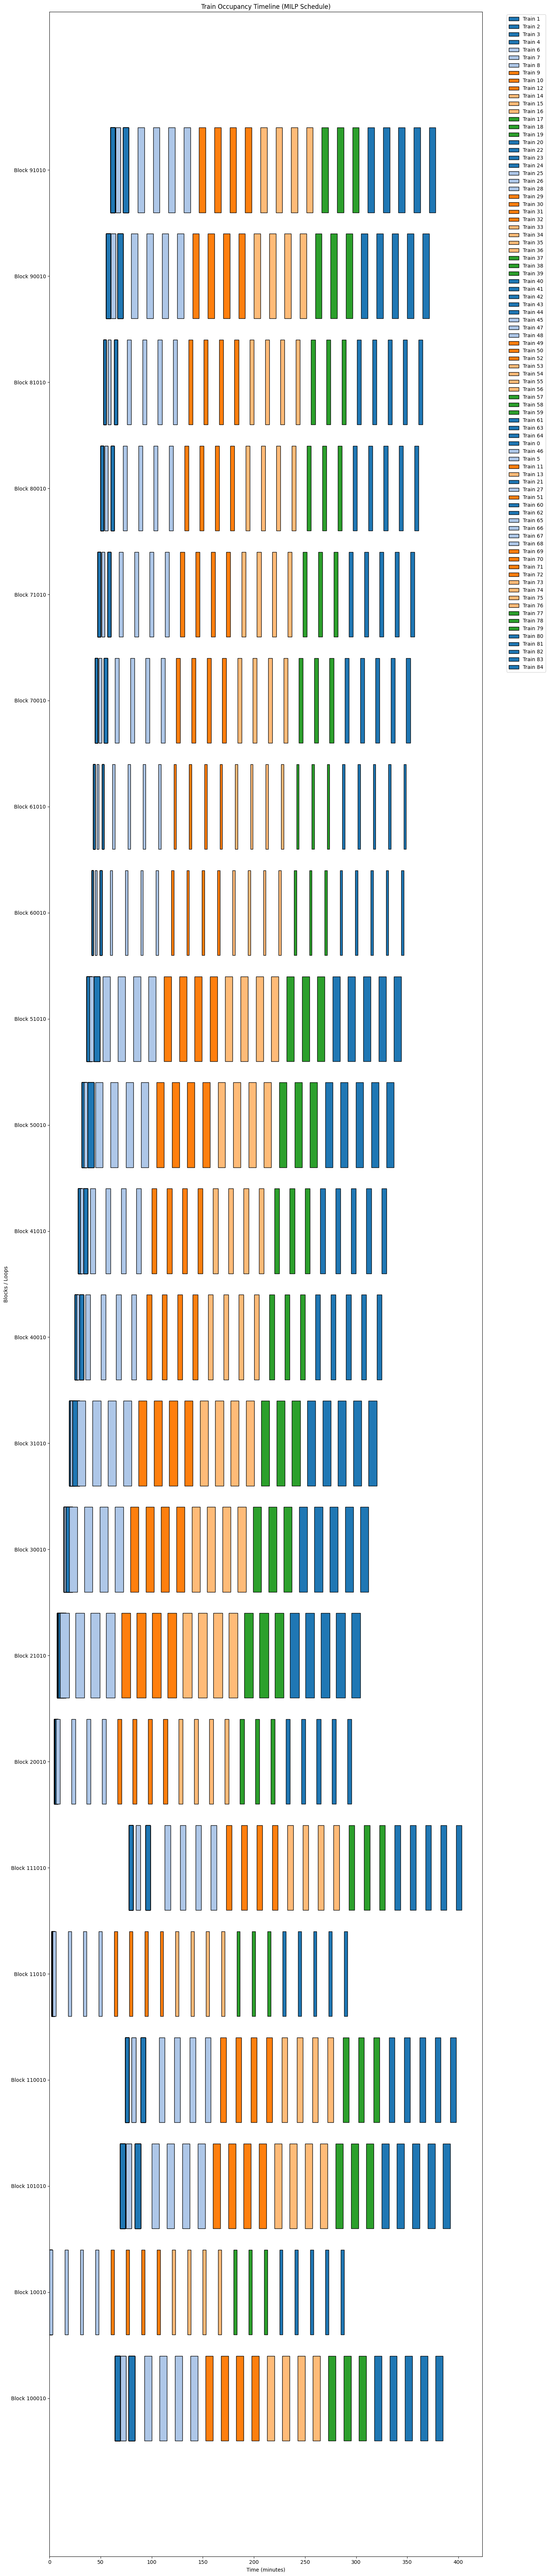

In [51]:
import matplotlib.pyplot as plt

# Prepare data
timeline_data = []

# Blocks
for b_id, b_row in blocks.iterrows():
    for t_id, t_row in trains.iterrows():
        key = (t_row['train_id'], b_row['block_id'])
        if key in e and key in l:
            entry = value(e[key])
            exit = value(l[key])
            if entry is not None and exit is not None:
                timeline_data.append({
                    'train': t_row['train_id'],
                    'section': f"Block {b_row['block_id']}",
                    'start': entry,
                    'end': exit
                })

# Loops
for l_id, l_row in loops.iterrows():
    for t_id, t_row in trains.iterrows():
        key = (t_row['train_id'], l_row['loop_id'])
        if key in e and key in l:
            entry = value(e[key])
            exit = value(l[key])
            if entry is not None and exit is not None:
                timeline_data.append({
                    'train': t_row['train_id'],
                    'section': f"Loop {l_row['loop_id']}",
                    'start': entry,
                    'end': exit
                })

# Sort data by section and train
timeline_data.sort(key=lambda x: (x['section'], x['start']))

# Plot
fig, ax = plt.subplots(figsize=(15, len(blocks)+len(loops)))

sections = sorted(set(d['section'] for d in timeline_data))
section_idx = {s: i for i, s in enumerate(sections)}

colors = plt.cm.get_cmap('tab20', len(trains))

for d in timeline_data:
    ax.barh(section_idx[d['section']], d['end'] - d['start'], left=d['start'], 
            color=colors(d['train'] % 20), edgecolor='black', label=f"Train {d['train']}")

ax.set_yticks(list(section_idx.values()))
ax.set_yticklabels(list(section_idx.keys()))
ax.set_xlabel("Time (minutes)")
ax.set_ylabel("Blocks / Loops")
ax.set_title("Train Occupancy Timeline (MILP Schedule)")

# Optional: Remove duplicate legend entries
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [52]:
import matplotlib.pyplot as plt

# Throughput counts
throughput = {}

# Blocks
for b_id, b_row in blocks.iterrows():
    count = 0
    for t_id, t_row in trains.iterrows():
        key = (t_row['train_id'], b_row['block_id'])
        if key in x and value(x[key]) == 1:
            count += 1
    throughput[f"Block {b_row['block_id']}"] = count

# Loops
for l_id, l_row in loops.iterrows():
    count = 0
    for t_id, t_row in trains.iterrows():
        key = (t_row['train_id'], l_row['loop_id'])
        if key in x and value(x[key]) == 1:
            count += 1
    throughput[f"Loop {l_row['loop_id']}"] = count


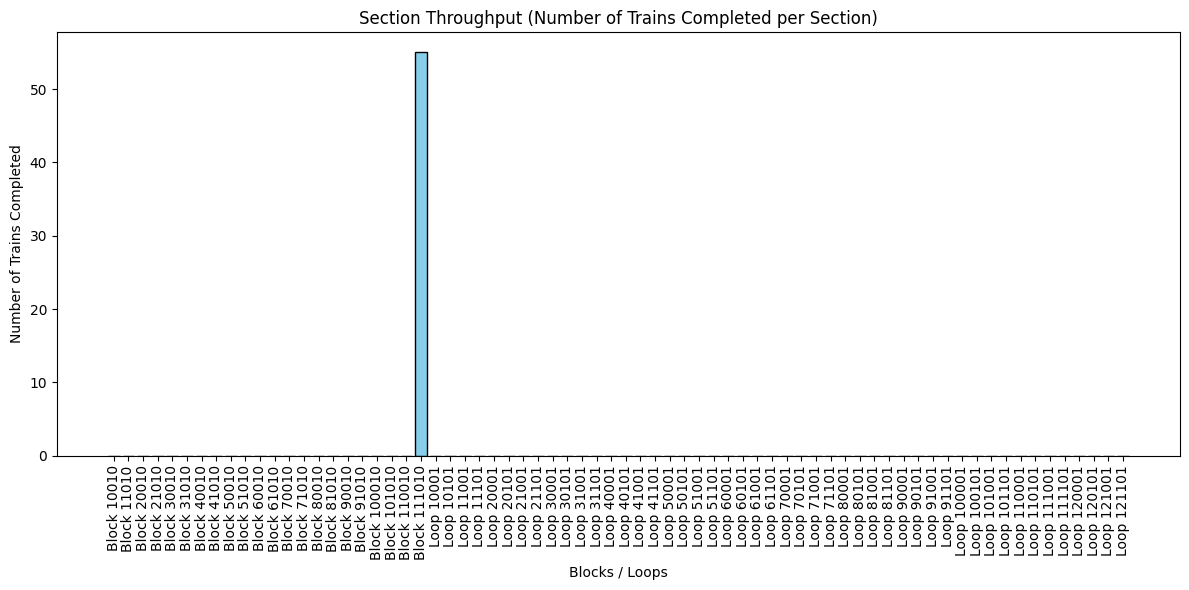

In [53]:
# Sort sections by order (optional)
sections = list(throughput.keys())
values = [throughput[s] for s in sections]

plt.figure(figsize=(12,6))
plt.bar(sections, values, color='skyblue', edgecolor='black')
plt.xticks(rotation=90)
plt.ylabel("Number of Trains Completed")
plt.xlabel("Blocks / Loops")
plt.title("Section Throughput (Number of Trains Completed per Section)")
plt.tight_layout()
plt.show()


/var/folders/mk/tvz_pqr97_778k6rbbp07ylm0000gn/T/ipykernel_95559/4231843978.py:23: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



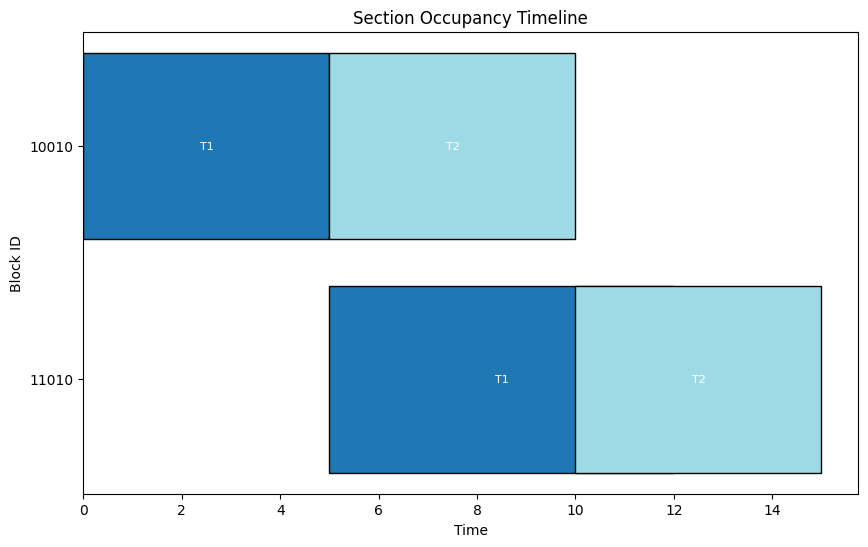

In [56]:
import matplotlib.pyplot as plt

# Sample occupancy data
# Each row: (train_id, block_id, start_time, end_time)
data = [
    ("T1", "10010", 0, 5),
    ("T2", "10010", 5, 10),
    ("T1", "11010", 5, 12),
    ("T2", "11010", 10, 15),
    # Add your real data here
]

# Extract unique blocks and trains
blocks = sorted(list({row[1] for row in data}))
trains = sorted(list({row[0] for row in data}))

# Assign y positions for blocks
block_pos = {block: i for i, block in enumerate(blocks)}

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

colors = plt.cm.get_cmap("tab20", len(trains))  # distinct colors for trains
train_color = {train: colors(i) for i, train in enumerate(trains)}

for train_id, block_id, start, end in data:
    ax.barh(block_pos[block_id], end - start, left=start, color=train_color[train_id], edgecolor='black')
    ax.text((start+end)/2, block_pos[block_id], train_id, va='center', ha='center', color='white', fontsize=8)

ax.set_yticks(list(block_pos.values()))
ax.set_yticklabels(list(block_pos.keys()))
ax.set_xlabel("Time")
ax.set_ylabel("Block ID")
ax.set_title("Section Occupancy Timeline")
plt.gca().invert_yaxis()  # optional: show lower block at bottom
plt.show()
